# Simple Neural Network

To make understanding the subject better (especially backpropagation), we'll make a simple neural network that is equivalent to an AND gate.

In [303]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.lines as lin
import traceback

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

In [617]:
def plotnodes(wl,sl=None):
    """
    wl: a list of weight matrix for each layer of neural network.
    """
    fig, ax = plt.subplots()
    l1 = lin.Line2D([-1,-1],[1,1], transform=fig.transFigure, figure=fig, color='r', linewidth=5)
    fig.lines.extend([l1])
    fig.canvas.draw()
    if sl is not None:
        smax = max(1., np.max([np.max(np.abs(x)) for x in sl]))
        if len(sl) < len(wl)+1:
            raise Exception('sl must have a length of len(wl)+1')
    for n in range(len(wl)):
        w = wl[n]
        if sl is not None:
            if len(sl[n]) < np.shape(w)[1]:
                c1 = np.concatenate((sl[n],[-1]),0) / smax
            else:
                c1 = sl[n] / smax
            if len(sl[n+1]) < np.shape(w)[1]:
                c2 = sl[n+1] / smax
            else:
                c2 = sl[n+1][:-1] / smax
        else:
            c1 = 0.5*np.ones(np.shape(w)[1])
            c2 = 0.5*np.ones(np.shape(w)[0])
        ax.scatter(n+np.zeros(np.shape(w)[1]), range(np.shape(w)[1]), 100, c=c1, cmap='gray', edgecolor='black')
        ax.scatter(n+np.ones(np.shape(w)[0]), range(np.shape(w)[0]), 100, c=c2, cmap='gray', edgecolor='black')
        for i in range(len(w)):
            start = w[i]
            for j in range(len(start)):
                ax.plot([n,n+1],[j,i], linewidth=min(10,abs(start[j])), color='k' if 0 < start[j] else 'r')
    ax.set_ylim(np.max([np.shape(x)[1] for x in wl]),-1)



(1, 3)


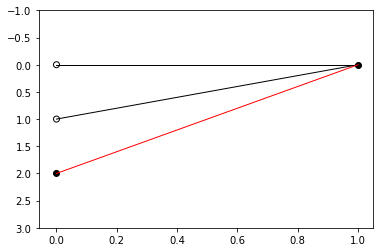

In [618]:
in1 = [np.array([0,0]),np.array([0])]

weights = [[[1,1,-1]]]
print(np.shape(weights[0]))

plotnodes(weights,in1)

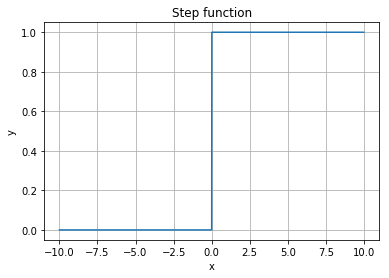

In [102]:
def step(x):
    return 0 < x

x = np.arange(-10,10,0.01)
plt.plot(x, step(x));
plt.grid();
plt.title(r'Step function')
plt.xlabel('x')
plt.ylabel('y');

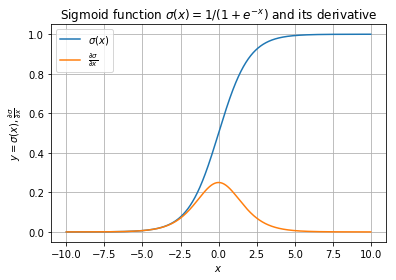

In [812]:
def sigmoid(x):
    #return 1 / (1 + np.exp(-x)) * 2 - 1
    return 1 / (1 + np.exp(-x))

def grad_sigmoid(x):
    #return 2 * np.exp(-x) / (1 + np.exp(-x)) ** 2
    return np.exp(-x) / (1 + np.exp(-x)) ** 2

x = np.arange(-10,10,0.01)
plt.plot(x, np.transpose([sigmoid(x), grad_sigmoid(x)]));
plt.grid();
plt.title(r'Sigmoid function $\sigma(x)=1/(1+e^{-x})$ and its derivative')
plt.legend([r'$\sigma(x)$', r'$\frac{\partial \sigma}{\partial x}$'])
plt.xlabel('$x$')
plt.ylabel(r'$y=\sigma(x), \frac{\partial \sigma}{\partial x}$')

In [563]:
def forward(x,weights):
    sums = []
    products = []
    xs = []
    for w in weights:
        x = np.concatenate((np.array(x),np.array([-1])),0)
        xs.append(x)
        # Append bias term
        product = w * x
        xsum = np.sum(product,1)
        x = sigmoid(xsum).T
        sums.append(xsum)
        products.append(product)
    return x, sums, xs, products

In [691]:
loss_history = []
regulator = 0.000
learn_rate = 0.1
backward_verbose = 5

def backward(im,ans,weights):
    global loss_history
    predicted, sums, signals, products = forward(im,weights)
    ans = np.array(ans)
    loss = ans * np.log(predicted) + ((1. - ans) * np.log(1. - predicted))
    dloss = predicted - ans
    loss_history.append(loss.dot(loss))
    signals.append(predicted)
    if len(loss_history) < backward_verbose:
        print('[train %d]' % len(loss_history))
        print('\tsums', sums)
        print('\tpredicted = ', predicted, ', ans = ', ans, ', loss = ', loss)
        print('\tL = ', loss.dot(loss))
    for n in range(len(weights)-1,-1,-1):
        w = weights[n]
        if len(loss_history) < backward_verbose:
            print('\tsums[%d]' % n, sums[n])
            print('\tshapes at this point: dloss', dloss.shape, 'signals[n]', signals[n].shape)
            print('\tsubtracted from w = ', learn_rate * np.matmul(np.matrix(dloss).T, np.matrix(signals[n])) * (1 - regulator * np.linalg.norm(w)))
        w -= learn_rate * np.matmul(np.matrix(dloss).T, np.matrix(signals[n])) * (1 - regulator * np.linalg.norm(w))
        if 1 <= n:
            if len(loss_history) < backward_verbose:
                print('\tshapes at this point: w', w.shape, 'dloss', type(dloss), 'signals[n]', type(signals[n]))
            grad = np.matrix(signals[n+1] * (1 - signals[n+1]) * dloss)
            if len(loss_history) < backward_verbose:
                print('\tgrad[%d]' % n, grad, ', shape = ', grad.shape, ', grad * loss = ', grad)
            #grad = grad.reshape((len(grad),1))
            dloss = np.matmul(w.T, grad)[:-1].T
            if len(loss_history) < backward_verbose:
                print('\tshapes at this point: w', w.shape, 'grad', grad.shape, 'dloss', dloss.shape)
                print('\tsignals[%d]' % n, signals[n])
                print('\tnext loss', loss)
                print('\tproducts[%d]' % n, products[n])
        if len(loss_history) < backward_verbose:
            print('\tresults in ', w)
        if (1e3 < abs(w)).any():
            print('warning! w[%d] ' % n, w)
            raise Exception('w[%d] diverges' % n)
    return weights

weights before training [array([[ 0.05471757, -0.02539793,  0.04464217]])]
[train 1]
	sums [array([-0.04464217])]
	predicted =  [ 0.48884131] , ans =  [0] , loss =  [-0.48884131]
	L =  0.238965826676
	sums[0] [-0.04464217]
	grad[0] [ 0.24987548] , shape =  (1,) , grad * loss =  [-0.12214946]
	shapes at this point: w (1, 3) grad (1, 1) loss (2,)
	signals[0] [ 0  0 -1]
	next loss [-0.00668372  0.00310234]
	products[0] [[ 0.         -0.         -0.04464217]]
	subtracted from w =  [[-0.         -0.          0.01221495]]
	results in  [[ 0.05471757 -0.02539793  0.05685712]]
[train 2]
	sums [array([-0.08225505])]
	predicted =  [ 0.47944782] , ans =  [1] , loss =  [ 0.52055218]
	L =  0.270974567197
	sums[0] [-0.08225505]
	grad[0] [ 0.24957761] , shape =  (1,) , grad * loss =  [ 0.12991817]
	shapes at this point: w (1, 3) grad (1, 1) loss (2,)
	signals[0] [ 0  1 -1]
	next loss [ 0.00710881 -0.00329965]
	products[0] [[ 0.         -0.02539793 -0.05685712]]
	subtracted from w =  [[ 0.          0.0

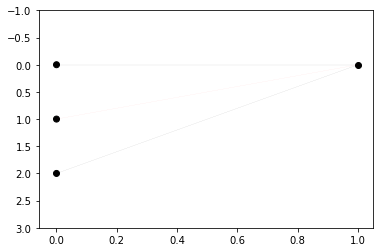

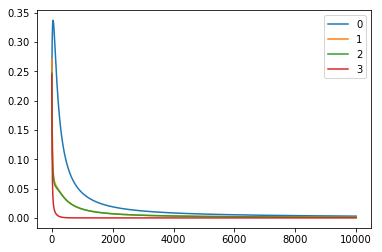

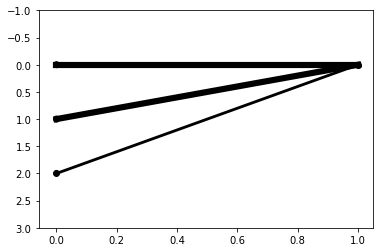

In [692]:
# Randomize the weights
weights = [0.3*(np.random.random((1,3))-0.5)]
#weights = [np.array([[0.1, 6, 3]])]

print('weights before training', weights)
plotnodes(weights)

training_set = [
    [[0,0],[0]],
    [[0,1],[1]],
    [[1,0],[1]],
    [[1,1],[1]],
]

loss_history.clear()
try:
    for i in range(10000):
        for v in training_set:
            weights = backward(v[0],v[1], weights)
except Exception as e:
    print(e)
    print(traceback.format_exc())

print('final weights = ', weights)
plt.figure()
plt.plot(np.array(loss_history).reshape(len(loss_history)//4,4), '-')
plt.legend(range(4))
#plt.plot(loss_history)
plotnodes(weights)


Check if our training works

In [662]:
#weights = [np.array([[1.,1.,1.]])]
for i in training_set:
    print('input: ', i[0], ', expected: ', forward(i[0],weights)[0], ', real: ', i[1])

input:  [0, 0] , expected:  [ 0.05503505] , real:  [0]
input:  [0, 1] , expected:  [ 0.96563986] , real:  [0]
input:  [1, 0] , expected:  [ 0.96563249] , real:  [0]
input:  [1, 1] , expected:  [ 0.99992625] , real:  [1]


Let's fiddle around with sliders

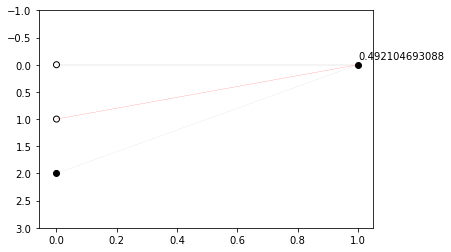

In [470]:
def pltnn(a,b):
    l1s = forward([a,b],weights)[0]
    plotnodes(weights,[[a,b],l1s]);
    plt.annotate(l1s[0], xy=(1,-0.1))

pixrange = (-1,1,0.1)
interact(pltnn, a=pixrange, b=pixrange);

Let's move on to a bit more complex example.

weights before training [array([[ 0.09582493, -0.07431531, -0.00444498],
       [ 0.07488485,  0.00633638,  0.05220103]]), array([[ 0.10264931,  0.11720921,  0.01291609]])]
[train 1]
	sums [array([ 0.00444498, -0.05220103]), array([ 0.09559797])]
	predicted =  [ 0.52388131] , ans =  [0] , loss =  [-0.52388131]
	L =  0.274451625331
	sums[1] [ 0.09559797]
	grad[1] [ 0.24942968] , shape =  (1,) , grad * loss =  [-0.13067155]
	shapes at this point: w (1, 3) grad (1, 1) loss (2,)
	signals[1] [ 0.50111124  0.48695271 -1.        ]
	next loss [-0.01341334 -0.01531591]
	products[1] [[ 0.05143872  0.05707534 -0.01291609]]
	subtracted from w =  [[-0.0065481  -0.00636309  0.01306715]]
	results in  [[ 0.09610121  0.11084612  0.02598325]]
	sums[0] [ 0.00444498 -0.05220103]
	grad[0] [ 0.24999877  0.24982977] , shape =  (2,) , grad * loss =  [-0.00335332 -0.00382637]
	shapes at this point: w (2, 3) grad (2, 1) loss (2,)
	signals[0] [ 0  0 -1]
	next loss [-0.00060787  0.00022496]
	products[0] [[ 0.    

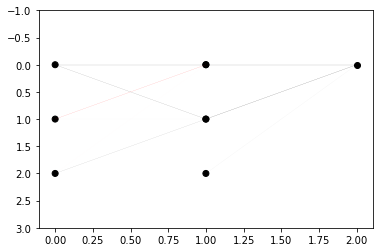

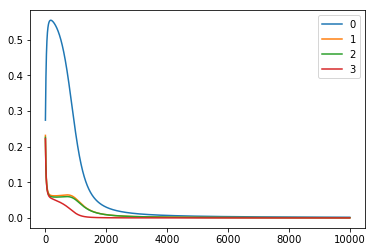

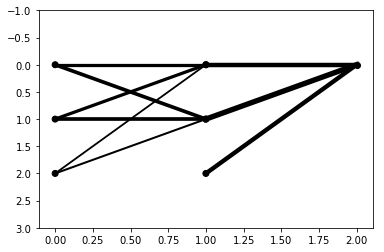

In [693]:
# Randomize the weights

weights = [0.3*(np.random.random((2,3))-0.5),
           #0.3*(np.random.random((2,3))-0.5),
          0.3*(np.random.random((1,3))-0.5)]
#weights = [np.array([[10,1,0.5],[-1,10,0.5]],dtype=float),
           #np.array([[1,0,0],[0,1,-1]],dtype=float),
#          np.array([[5,5,6]],dtype=float)]

print('weights before training', weights)
plotnodes(weights)

training_set = [
    [[0,0],[0]],
    [[0,1],[1]],
    [[1,0],[1]],
    [[1,1],[1]],
]

loss_history.clear()
try:
    for i in range(10000):
        for v in training_set:
            weights = backward(v[0], v[1], weights)
except Exception as e:
    print(e)
    print(traceback.format_exc())

plt.figure()
plt.plot(np.array(loss_history).reshape(len(loss_history)//4,4), '-')
plt.legend(range(4))
#plt.plot(loss_history)
plotnodes(weights)


In [690]:
#weights = [np.array([[0,10,0],[10,0,0]],dtype=float),
#          np.array([[5,5,6]],dtype=float)]
for i in training_set:
    print('expected: ', forward(i[0],weights)[0], ', real: ', i[1])

expected:  [ 0.04262921] , real:  [0]
expected:  [ 0.97672321] , real:  [1]
expected:  [ 0.97667145] , real:  [1]
expected:  [ 0.99547813] , real:  [1]


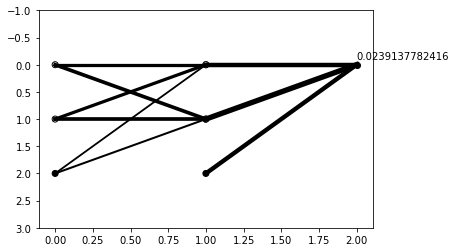

In [694]:
def pltnn(a,b):
    l1s, _, signals, _ = forward([a,b],weights)
    signals.append(np.array(l1s))
    plotnodes(weights, signals);
    plt.annotate(l1s[0], xy=(len(weights),-0.1))

pixrange = (-1,1,0.1)
interact(pltnn, a=pixrange, b=pixrange);